In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "ERF"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = False

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
11654,Oropetium_20150105_23219A,MATVHPGSPGPTATPIPPPPPEGRHGDAPGPPAASGDAAVPADGGE...,259,1
28382,GSBRNA2T00144257001,MEYVCVVEAKDGTISVATAFAGHQQAVQDSDHKFLTQAVEEAYKGV...,603,0
602,Aqcoe3G269100.1.p,MATTTPDEASTIDLIRQHLLGDFASLESFLNSDFSFCNSKLQSEND...,318,1
23472,XP_009771319.1,MALETLNSPTTTTPPTFQFENNGQLRYLENWTKGKRSKRPRSMERQ...,253,0
32127,Sof004495,MGRSPCCEKEAGLKKGPWTPEEDQKLLAFIEQHGHGCWRSLPAKAG...,207,0


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 11654 to 7344
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        5000 non-null   object
 1   sequence  5000 non-null   object
 2   length    5000 non-null   int64 
 3   class     5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 195.3+ KB


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) #, random_state=42
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1580,0.011811,0.0,0.003937,0.007874,0.000000,0.000000,0.003937,0.000000,0.000000,0.007874,...,0.000000,0.000000,0.000000,0.003937,0.000000,0.0,0.0,0.0,0.000000,0.000000
3296,0.024631,0.0,0.000000,0.004926,0.000000,0.000000,0.000000,0.004926,0.004926,0.000000,...,0.004926,0.004926,0.000000,0.004926,0.000000,0.0,0.0,0.0,0.000000,0.000000
3778,0.009036,0.0,0.009036,0.015060,0.006024,0.000000,0.000000,0.003012,0.003012,0.000000,...,0.000000,0.000000,0.006024,0.006024,0.006024,0.0,0.0,0.0,0.000000,0.000000
2188,0.041420,0.0,0.008876,0.002959,0.000000,0.005917,0.002959,0.002959,0.002959,0.011834,...,0.000000,0.002959,0.002959,0.000000,0.011834,0.0,0.0,0.0,0.000000,0.014793
1605,0.030435,0.0,0.000000,0.008696,0.004348,0.004348,0.013043,0.000000,0.000000,0.013043,...,0.000000,0.004348,0.000000,0.004348,0.000000,0.0,0.0,0.0,0.004348,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 21s 443ms/step - accuracy: 0.5312 - loss: 0.6930

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6651 - loss: 0.6783   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7038 - loss: 0.6556 - val_accuracy: 0.9550 - val_loss: 0.2069


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9062 - loss: 0.2718

39/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9505 - loss: 0.1607

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9533 - loss: 0.1508 - val_accuracy: 0.9775 - val_loss: 0.0754


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0276

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9726 - loss: 0.0773

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9732 - loss: 0.0763 - val_accuracy: 0.9800 - val_loss: 0.0646


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0824

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9830 - loss: 0.0595

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9829 - loss: 0.0580 - val_accuracy: 0.9775 - val_loss: 0.0731


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0281

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0441

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9881 - loss: 0.0446 - val_accuracy: 0.9837 - val_loss: 0.0570


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0171

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9878 - loss: 0.0355

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0359 - val_accuracy: 0.9825 - val_loss: 0.0602


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0094

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0230

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0247 - val_accuracy: 0.9787 - val_loss: 0.0665


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0040

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0241

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0241 - val_accuracy: 0.9800 - val_loss: 0.0627


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0292

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0284

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0268 - val_accuracy: 0.9825 - val_loss: 0.0586


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0098

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0116 - val_accuracy: 0.9825 - val_loss: 0.0649


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0018

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0141

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0152 - val_accuracy: 0.9812 - val_loss: 0.0661


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0160

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9891 - loss: 0.0293

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9892 - loss: 0.0287 - val_accuracy: 0.9825 - val_loss: 0.0620


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9844 - loss: 0.0417

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0256

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0242 - val_accuracy: 0.9825 - val_loss: 0.0620


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0019

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0121

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0105 - val_accuracy: 0.9850 - val_loss: 0.0660


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0021

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0052

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0075 - val_accuracy: 0.9800 - val_loss: 0.0745


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.7226e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0067    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0075 - val_accuracy: 0.9862 - val_loss: 0.0712


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0041

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0106

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0118 - val_accuracy: 0.9762 - val_loss: 0.0994


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0202

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0108

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0113 - val_accuracy: 0.9837 - val_loss: 0.0693


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0063

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9950 - loss: 0.0095

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0087 - val_accuracy: 0.9837 - val_loss: 0.0739


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0126

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0036

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0034 - val_accuracy: 0.9825 - val_loss: 0.0785


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1701e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0019    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0022 - val_accuracy: 0.9862 - val_loss: 0.0760


Epoch 22/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0058

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0024

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0020 - val_accuracy: 0.9850 - val_loss: 0.0799


Epoch 23/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.1716e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0019    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0022 - val_accuracy: 0.9837 - val_loss: 0.0840


Epoch 24/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8661e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0013    

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9775 - val_loss: 0.1146


Epoch 25/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0594e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.0317e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9787 - val_loss: 0.1001


Epoch 26/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0037

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0047

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0047 - val_accuracy: 0.9775 - val_loss: 0.1017



[Train Accuracy: 99.84% - Test Accuracy: 96.80%]


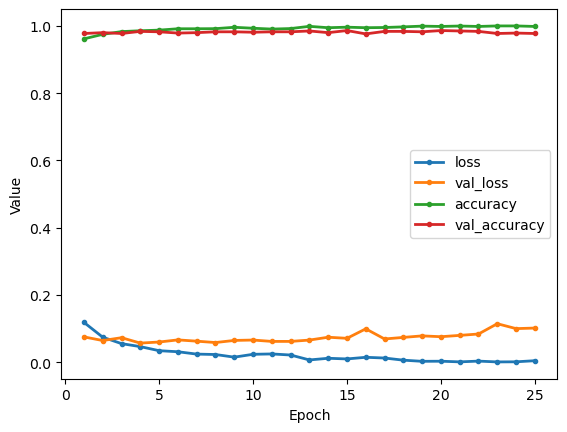

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1621,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.000000,0.003195,0.0,0.003195,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4337,0.001387,0.0,0.0,0.00000,0.001387,0.000000,0.001387,0.001387,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2937,0.018617,0.0,0.0,0.00000,0.000000,0.007979,0.000000,0.000000,0.0,0.002660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4530,0.004950,0.0,0.0,0.00495,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2922,0.025157,0.0,0.0,0.00000,0.006289,0.000000,0.000000,0.006289,0.0,0.006289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8764)
X_test: (1000, 8764)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,243,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,287,105 (8.72 MB)

 Trainable params: 2,287,105 (8.72 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 22s 462ms/step - accuracy: 0.4844 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5254 - loss: 0.6926   

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5311 - loss: 0.6920

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5503 - loss: 0.6903

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5810 - loss: 0.6869

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6147 - loss: 0.6795

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6413 - loss: 0.6684

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6444 - loss: 0.6668 - val_accuracy: 0.9837 - val_loss: 0.2100


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9375 - loss: 0.2366

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9653 - loss: 0.1942 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9729 - loss: 0.1615

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9764 - loss: 0.1417

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9788 - loss: 0.1272

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9805 - loss: 0.1161

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9812 - loss: 0.1111 - val_accuracy: 0.9900 - val_loss: 0.0393


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9844 - loss: 0.0364

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9928 - loss: 0.0200 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9943 - loss: 0.0179

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9943 - loss: 0.0196

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9944 - loss: 0.0201

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9946 - loss: 0.0199

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9946 - loss: 0.0197

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9947 - loss: 0.0195 - val_accuracy: 0.9887 - val_loss: 0.0384


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0026

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0031 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0043

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0046

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0061

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9990 - loss: 0.0066

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9990 - loss: 0.0067 - val_accuracy: 0.9937 - val_loss: 0.0322


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0020

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0065 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0076

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0072

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0070

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0069

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0067 - val_accuracy: 0.9937 - val_loss: 0.0329


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 6.8005e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9983 - loss: 0.0085     

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0075

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0068

35/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0063

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.0058

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0054 - val_accuracy: 0.9937 - val_loss: 0.0346


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 2.7809e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1988e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4006e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4162e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3645e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3531e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3389e-04 - val_accuracy: 0.9925 - val_loss: 0.0362


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 3.4850e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8789e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9869e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.8532e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7797e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.7142e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6132e-04 - val_accuracy: 0.9937 - val_loss: 0.0380


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.2509e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9927e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7476e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7042e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6584e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6385e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6336e-04 - val_accuracy: 0.9937 - val_loss: 0.0398


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.8250e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8227e-04 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9163e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.9387e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.2613e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4520e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5810e-04 - val_accuracy: 0.9937 - val_loss: 0.0413


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 1.9059e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5144e-04 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6197e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8558e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8826e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.8786e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8572e-04 - val_accuracy: 0.9937 - val_loss: 0.0442


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.1189e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.8974e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.4283e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8136e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0803e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.4132e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.4942e-05 - val_accuracy: 0.9937 - val_loss: 0.0460


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.8692e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4788e-05 

19/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4286e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.0782e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2972e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.3413e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3332e-05 - val_accuracy: 0.9925 - val_loss: 0.0474


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6422e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7762e-05 

18/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6102e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7339e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.8844e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9376e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0747e-05 - val_accuracy: 0.9937 - val_loss: 0.0490



[Train Accuracy: 100.00% - Test Accuracy: 99.00%]


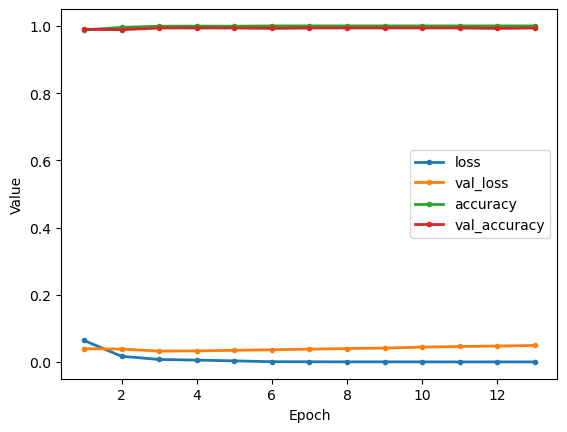

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
1621,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4337,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.001389,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2937,0.008000,0.0,0.0,0.0,0.000000,0.002667,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4530,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2922,0.012658,0.0,0.0,0.0,0.006329,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,617,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,658,689 (139.84 MB)

 Trainable params: 36,658,689 (139.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 32s 661ms/step - accuracy: 0.5469 - loss: 0.6931

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.5586 - loss: 0.6931 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.5668 - loss: 0.6929

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5658 - loss: 0.6929

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.5576 - loss: 0.6930

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 0.5541 - loss: 0.6930

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5546 - loss: 0.6928

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5542 - loss: 0.6927

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5522 - loss: 0.6926

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5506 - loss: 0.6926

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5492 - loss: 0.6925

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5467 - loss: 0.6924

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5443 - loss: 0.6924

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5426 - loss: 0.6924

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5410 - loss: 0.6923

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5395 - loss: 0.6922

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5379 - loss: 0.6921

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5366 - loss: 0.6920

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5357 - loss: 0.6919

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 0.5351 - loss: 0.6917

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.5343 - loss: 0.6916

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5336 - loss: 0.6914

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5329 - loss: 0.6912

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 0.5321 - loss: 0.6910

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5317 - loss: 0.6908

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5317 - loss: 0.6906

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5322 - loss: 0.6904

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5332 - loss: 0.6901

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5346 - loss: 0.6898

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5363 - loss: 0.6895

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5382 - loss: 0.6891

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5402 - loss: 0.6888

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.5424 - loss: 0.6884

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5448 - loss: 0.6880

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5474 - loss: 0.6875

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5500 - loss: 0.6870

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.5527 - loss: 0.6865

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5556 - loss: 0.6859

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5585 - loss: 0.6853

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5614 - loss: 0.6847

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.5644 - loss: 0.6840

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5674 - loss: 0.6833

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5704 - loss: 0.6825

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5735 - loss: 0.6817

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5765 - loss: 0.6808

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5795 - loss: 0.6799

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5825 - loss: 0.6790

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5855 - loss: 0.6779

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5885 - loss: 0.6769

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5915 - loss: 0.6757

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.5944 - loss: 0.6746 - val_accuracy: 0.9862 - val_loss: 0.3565


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 212ms/step - accuracy: 1.0000 - loss: 0.3449

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9961 - loss: 0.3334 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.9939 - loss: 0.3260

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9935 - loss: 0.3198

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9935 - loss: 0.3133

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9937 - loss: 0.3074

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9940 - loss: 0.3019

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9938 - loss: 0.2966

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9937 - loss: 0.2914

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9937 - loss: 0.2864

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9938 - loss: 0.2814

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9938 - loss: 0.2765

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9939 - loss: 0.2719

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 0.9939 - loss: 0.2675

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 0.9938 - loss: 0.2633

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9938 - loss: 0.2593

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9937 - loss: 0.2554

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9937 - loss: 0.2515

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9936 - loss: 0.2478

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9935 - loss: 0.2442

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9934 - loss: 0.2407

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.9933 - loss: 0.2373

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9933 - loss: 0.2340

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9932 - loss: 0.2308

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9931 - loss: 0.2276

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.9931 - loss: 0.2246

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9930 - loss: 0.2216

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9930 - loss: 0.2188

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9929 - loss: 0.2160

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9929 - loss: 0.2132

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9929 - loss: 0.2106

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9929 - loss: 0.2081

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9928 - loss: 0.2057

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9928 - loss: 0.2034

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9928 - loss: 0.2011

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9927 - loss: 0.1988

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9927 - loss: 0.1966

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9927 - loss: 0.1945

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9927 - loss: 0.1923

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9927 - loss: 0.1903

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9927 - loss: 0.1883

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9927 - loss: 0.1864

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9927 - loss: 0.1845

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9927 - loss: 0.1826

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9927 - loss: 0.1808

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9927 - loss: 0.1791

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9927 - loss: 0.1774

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9927 - loss: 0.1757

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9927 - loss: 0.1741

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9927 - loss: 0.1725

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9927 - loss: 0.1710 - val_accuracy: 0.9875 - val_loss: 0.0395


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9844 - loss: 0.0207

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9844 - loss: 0.0290

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9844 - loss: 0.0306

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9854 - loss: 0.0295

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.9864 - loss: 0.0281

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9874 - loss: 0.0267

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9882 - loss: 0.0254

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 0.9890 - loss: 0.0241

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.9896 - loss: 0.0231

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9902 - loss: 0.0221

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9907 - loss: 0.0212

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9911 - loss: 0.0205

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9915 - loss: 0.0198

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.9918 - loss: 0.0192

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.9921 - loss: 0.0187

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9923 - loss: 0.0183

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9925 - loss: 0.0179

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9926 - loss: 0.0177

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9928 - loss: 0.0176

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9929 - loss: 0.0175

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9930 - loss: 0.0173

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9932 - loss: 0.0171

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9932 - loss: 0.0170

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9933 - loss: 0.0169

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9934 - loss: 0.0168

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9935 - loss: 0.0166

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9936 - loss: 0.0165

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9937 - loss: 0.0164

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9938 - loss: 0.0162

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9939 - loss: 0.0161

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9940 - loss: 0.0160

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9940 - loss: 0.0158

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9941 - loss: 0.0157

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9942 - loss: 0.0156

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.9943 - loss: 0.0154

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - accuracy: 0.9943 - loss: 0.0153

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9944 - loss: 0.0152

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9945 - loss: 0.0150

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9946 - loss: 0.0149

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 0.9946 - loss: 0.0148

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9947 - loss: 0.0147

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 0.9948 - loss: 0.0146

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9948 - loss: 0.0144

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9949 - loss: 0.0143

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.9949 - loss: 0.0142

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9950 - loss: 0.0141

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9951 - loss: 0.0140

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9951 - loss: 0.0139

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9952 - loss: 0.0138

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.9952 - loss: 0.0137

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.9912 - val_loss: 0.0269


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - accuracy: 1.0000 - loss: 0.0019

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 0.0023

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0025

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 0.0025

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 0.0025

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0025

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 0.0025

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 0.0025

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0025

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 0.0024

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0024

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 0.0024

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0023

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0023

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 0.0023

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0023

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 0.0023

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0023

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0023

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0023

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0023

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0024

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0024

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 0.0024

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 0.0024

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0024

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0023

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0023

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0023

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0023

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0023

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 0.0023

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 0.0023

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0023

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0023

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0023

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0023

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0023

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 0.0023

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 0.0022

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 1.0000 - loss: 0.0022

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0022

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0022

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0022

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0022

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0022

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0022

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0023

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9700 - val_loss: 0.0859


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - accuracy: 0.9844 - loss: 0.0236

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 0.9883 - loss: 0.0179

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9905 - loss: 0.0152

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.9919 - loss: 0.0134

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 0.9929 - loss: 0.0120

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 0.9936 - loss: 0.0110

 7/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9942 - loss: 0.0101

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9947 - loss: 0.0094

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9951 - loss: 0.0088

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9954 - loss: 0.0083

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.9957 - loss: 0.0079

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9960 - loss: 0.0075

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9962 - loss: 0.0072

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9964 - loss: 0.0069

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.9965 - loss: 0.0066

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9967 - loss: 0.0064

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9968 - loss: 0.0062

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9970 - loss: 0.0060

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9971 - loss: 0.0058

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9972 - loss: 0.0056

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 0.9973 - loss: 0.0054

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 0.9974 - loss: 0.0053

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9974 - loss: 0.0052

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9975 - loss: 0.0051

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9975 - loss: 0.0050

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9976 - loss: 0.0050

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9976 - loss: 0.0049

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9977 - loss: 0.0048

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9977 - loss: 0.0047

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9978 - loss: 0.0047

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9978 - loss: 0.0046

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9978 - loss: 0.0046

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9979 - loss: 0.0045

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9979 - loss: 0.0045

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9979 - loss: 0.0044

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9980 - loss: 0.0044

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9980 - loss: 0.0043

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9980 - loss: 0.0043

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9981 - loss: 0.0042

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9981 - loss: 0.0042

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.9981 - loss: 0.0042

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9982 - loss: 0.0041

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9982 - loss: 0.0041

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9982 - loss: 0.0040

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9982 - loss: 0.0040

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9983 - loss: 0.0040

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9983 - loss: 0.0039

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9983 - loss: 0.0039

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9983 - loss: 0.0038

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9983 - loss: 0.0038

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9984 - loss: 0.0038 - val_accuracy: 0.9825 - val_loss: 0.0456


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 223ms/step - accuracy: 1.0000 - loss: 5.3909e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 5.3353e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 5.4660e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.5348e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.5451e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.5306e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.4968e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.5538e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 5.7897e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 5.9617e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.0732e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.1567e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.2218e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.2599e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.3159e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.3497e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 6.3748e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 6.4086e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.4762e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.5839e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.6943e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.7840e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 6.8581e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9171e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 1.0000 - loss: 6.9662e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0045e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0352e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0582e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0793e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 1.0000 - loss: 7.0953e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.1053e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.1118e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 1.0000 - loss: 7.1144e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 7.1149e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 7.4172e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 7.6916e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 7.9428e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 1.0000 - loss: 8.1721e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9999 - loss: 8.3809e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9999 - loss: 8.5760e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.9999 - loss: 8.7542e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 8.9164e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 9.0652e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 9.2013e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9999 - loss: 9.3428e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 9.4782e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 9.6099e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 9.7612e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9999 - loss: 9.9027e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9999 - loss: 0.0010    

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - accuracy: 0.9999 - loss: 0.0010 - val_accuracy: 0.9725 - val_loss: 0.0784


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 1.0000 - loss: 8.6756e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.1366e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 6.8158e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 6.5844e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 6.4642e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 6.3124e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 6.1907e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 6.0638e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.9298e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.8139e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.6979e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.5832e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 1.0000 - loss: 5.5088e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 5.4547e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.4057e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 5.3563e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.3173e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.2868e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.2546e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 5.2277e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.2046e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.1832e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.1608e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 5.1384e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.1217e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.1064e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.0919e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.0762e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.0602e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.0426e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.0248e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 5.0069e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 5.0011e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 4.9949e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 4.9869e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 4.9797e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.9720e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 4.9643e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.9563e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.9483e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.9393e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9299e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9203e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9110e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.9018e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.8930e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.8886e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.8847e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 4.8802e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 4.8747e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 4.8694e-04 - val_accuracy: 0.9875 - val_loss: 0.0339


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 2.2819e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - accuracy: 1.0000 - loss: 2.4807e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 1.0000 - loss: 2.5428e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 2.5682e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.5775e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.5566e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.5274e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.5302e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.5768e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.5996e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.6093e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.6250e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.6386e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.6701e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.6996e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.7320e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.7532e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.7737e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.7954e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.8110e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8214e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8282e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8341e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8397e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.8443e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.8479e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.8515e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.8527e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.8526e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.8545e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.8545e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.8541e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.8524e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8498e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8479e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8455e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8428e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8396e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8357e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8585e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.8794e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.9002e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.9189e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.9362e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.9620e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.9857e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.0073e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.0270e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.0450e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.0621e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.0785e-04 - val_accuracy: 0.9862 - val_loss: 0.0345


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step - accuracy: 1.0000 - loss: 1.7720e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 1.0000 - loss: 1.8050e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.9973e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.0736e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 2.1242e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.1632e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 2.1806e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 2.1893e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.2079e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.2160e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 1.0000 - loss: 2.2154e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.2131e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.2088e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.2015e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.2066e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 2.2095e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.2123e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.2108e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.2078e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.2049e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 2.1998e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.1937e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.1923e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.1896e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.1909e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.1899e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.1880e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.1857e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.1840e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.1812e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.1773e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.1726e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.1681e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1631e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1593e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1555e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1514e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1469e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1422e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1373e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.1322e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.1273e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.1225e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.1183e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.1138e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.1095e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.1052e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.1006e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.0963e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.0920e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 2.0878e-04 - val_accuracy: 0.9850 - val_loss: 0.0434


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 1.0000 - loss: 1.9929e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.7507e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 1.6168e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 1.5586e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 1.4990e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4429e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 1.0000 - loss: 1.4065e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3747e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 1.3479e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.3248e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.3029e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 1.2990e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 1.2932e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.2907e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.2874e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 1.0000 - loss: 1.2875e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.2857e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.2837e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step - accuracy: 1.0000 - loss: 1.2833e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.2931e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.3035e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 120ms/step - accuracy: 1.0000 - loss: 1.3113e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.3179e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.3237e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3314e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3371e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3423e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3464e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3529e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3585e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3635e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3681e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.3720e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.3747e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.3855e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.3994e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.4116e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.4233e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.4336e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.4426e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.4505e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.4589e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.4681e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.4776e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.4866e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.4949e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.5024e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.5097e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.5163e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.5225e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.5283e-04 - val_accuracy: 0.9812 - val_loss: 0.0487


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 11s 230ms/step - accuracy: 1.0000 - loss: 9.7805e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 1.0000 - loss: 9.3020e-05 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 8.8097e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 8.6297e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 8.8175e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 8.9583e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 9.1412e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.2966e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 9.4648e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.6360e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.7190e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.7512e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 9.9509e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.0088e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.0175e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.0229e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.1037e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1699e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.2247e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.2707e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.3131e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.3495e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.3795e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.4044e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4266e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4453e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4608e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.4733e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.4853e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 1.4950e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.5035e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.5103e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5170e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5229e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5273e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.5311e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.5338e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5437e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5537e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.5622e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 1.5718e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.5807e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.5890e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.5968e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6037e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6098e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6153e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6201e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6244e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.6280e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 1.6314e-04 - val_accuracy: 0.9850 - val_loss: 0.0436


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - accuracy: 1.0000 - loss: 5.7416e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 5.8955e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 7.1511e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 7.4631e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 7.4681e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 7.4341e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 7.3475e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.2647e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 7.2662e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.2620e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.3080e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.3364e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.4888e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 7.6066e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.6968e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.7743e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.9982e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.2029e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 8.3669e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.4961e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.6630e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.8175e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 8.9534e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 9.0780e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 9.1799e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 9.2641e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 9.3396e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.4022e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.4536e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.4972e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 9.5354e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 9.5645e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 9.5889e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.6064e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 9.6181e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 9.6309e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 9.6432e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 9.6509e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 9.6543e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 9.6562e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 9.6555e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6538e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6513e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6482e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 9.6441e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6373e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6300e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6211e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6211e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 9.6195e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 1.0000 - loss: 9.6181e-05 - val_accuracy: 0.9837 - val_loss: 0.0453


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 175ms/step - accuracy: 1.0000 - loss: 6.5890e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 6.1187e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 6.4961e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 6.5239e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 6.5776e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 9.7182e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 1.1805e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.3124e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.4006e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.4548e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.4892e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 1.5132e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5261e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5304e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 1.5306e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5259e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5188e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 1.5097e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 1.5003e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 1.4918e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.4824e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.4721e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.4615e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.4502e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4389e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4278e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4174e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4069e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3964e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3855e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3752e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3648e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3544e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.3441e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.3341e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.3243e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.3148e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.3053e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.2963e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.2875e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.2924e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.2965e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3001e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3030e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3052e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3071e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3086e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3098e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.3106e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.3110e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 1.3115e-04 - val_accuracy: 0.9862 - val_loss: 0.0376



[Train Accuracy: 100.00% - Test Accuracy: 98.90%]


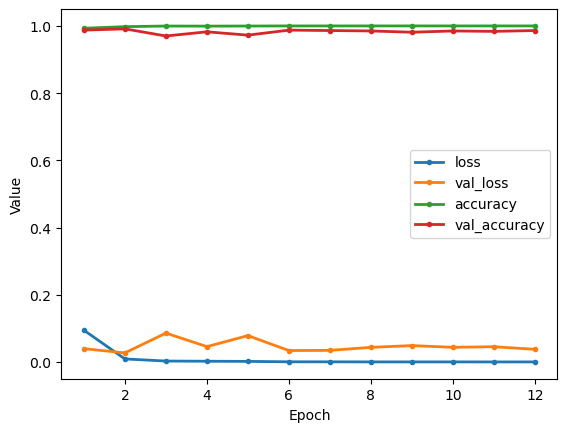

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step

 7/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [26]:
report.save()

Report saved as Output/Reports/ERF/report_2HBEU7WI.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [28]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [30]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [31]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [32]:
# END

In [33]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################